# ERA5 reanalysis on single levels on Earth Data Hub

***
This notebook will provide you guidance on how to access the reanalysis-era5-single-levels.zarr datset on Earth Data Hub.
The final goal is to compute the 2 metre temperature anomaly for the month of october 2023 against the 1981-2010 reference period.
***

### Key steps in this notebook:

1. import the necessary dependencies
2. declare convenience variables
3. preview the data
4. selection and reduction
6. plot the data

### Import dependences

In [1]:
import display
import matplotlib.pyplot as plt
import xarray as xr

### Define convenience variables

In [2]:
AREA = {"latitude": slice(55, 47), "longitude": slice(5, 16)}
DATASET = "s3://ecmwf-era5-single-levels/reanalysis-era5-single-levels.zarr"
LOCATION = {"latitude": 52.5, "longitude": 13.4}
REFERENCE_PERIOD = slice("1981", "2010")
MONTH = "2023-10"

### Workflow

***
Xarray and Dask work together following a lazy principle. This means that requested operations (methods) are performed only when actually needed, for instance when the `.compute()` or `.plot()` methods are called. 

To reduce the amount of data that will be downloaded and processed we perform the following steps:
1. preview
2. selection
3. reduction
4. plot
***

#### 1. Preview

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

In [3]:
ds = xr.open_dataset(DATASET, chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 735600, latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-29T17:46 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

#### 2. Selection

To reduce the downloaded data we perform a geographical selection corresponding to the EU Germany AREA. We also convert the temperature to °C degrees:

In [4]:
t2m = ds.t2m - 273.15
t2m.attrs["units"] = "C"
t2m_area = t2m.sel(**AREA)
t2m_area

<xarray.DataArray 't2m' (valid_time: 735600, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(735600, 33, 45), dtype=float32, chunksize=(2880, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

We can further select only the month of october 2023

In [9]:
t2m_area_month = t2m_area.sel(valid_time="2023-10")
t2m_area_month

<xarray.DataArray 't2m' (valid_time: 744, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(744, 33, 45), dtype=float32, chunksize=(480, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 2023-10-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

#### 2. Reduction

We can now compute the october monthly mean, reducing the data to a bi-dimensional shape:

In [5]:
t2m_area_month_mean = t2m_area_month.mean(dim="valid_time")
t2m_area_month_mean

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
dask.array<mean_agg-aggregate, shape=(33, 45), dtype=float32, chunksize=(33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 ...
    surface    float64 ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

Remember, the computation is actually performed only when the `.compute()` method is called

In [6]:
%%time
%%capture

t2m_area_month_mean = t2m_area_month_mean.compute()

CPU times: user 514 ms, sys: 207 ms, total: 721 ms
Wall time: 586 ms


#### 4. Plot
We can plot the result on a map.

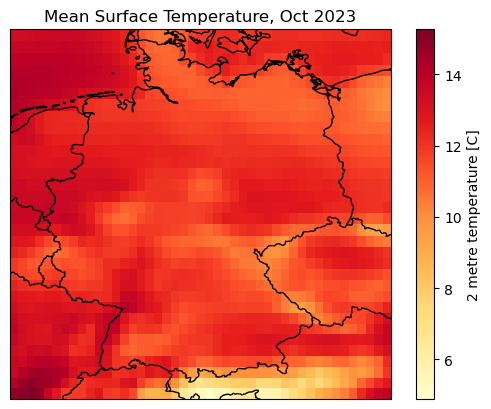

In [7]:
display.map(t2m_area_month_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Oct 2023")

### Monthly anomaly

Now, we want to compute the average October 2023 temperature anomaly on an area comprising the entire territory of Germany. 

The same considerations done before apply here.

In [10]:
t2m = ds.t2m - 273.15
t2m.attrs["units"] = "C"
t2m_area = t2m.sel(**AREA)
t2m_area

<xarray.DataArray 't2m' (valid_time: 735600, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(735600, 33, 45), dtype=float32, chunksize=(2880, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

In [11]:
t2m_month = t2m_area.sel(valid_time=t2m_area["valid_time.month"] == 10)
t2m_month

<xarray.DataArray 't2m' (valid_time: 62496, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(62496, 33, 45), dtype=float32, chunksize=(744, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-10-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

In [12]:
%%time

t2m_month = t2m_month.compute()
t2m_month_ref_mean = t2m_month.sel(valid_time=REFERENCE_PERIOD).mean(dim="valid_time")
t2m_month_year = t2m_area.sel(valid_time="2023-10")
t2m_month_year_mean = t2m_month_year.mean(dim="valid_time").compute()
t2m_month_year_anomaly = (t2m_month_year_mean - t2m_month_ref_mean)

CPU times: user 22.7 s, sys: 6.92 s, total: 29.6 s
Wall time: 22 s


Let's plot the results on a map.

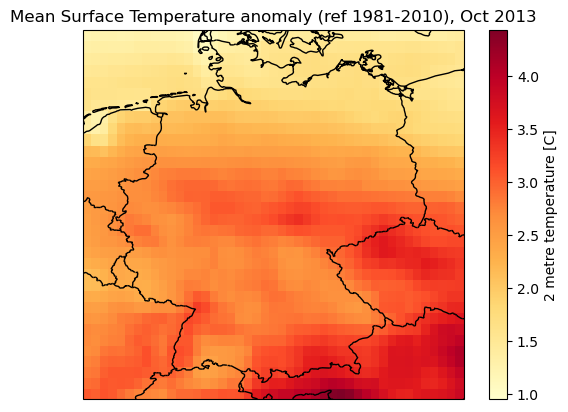

In [13]:
display.map(
    t2m_month_year_anomaly, 
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature anomaly (ref 1981-2010), Oct 2013"
)

### Climatology

Finally, we want to compute 2-metre Temperature climatology (mean and standard deviation for each month of the year) over the time range 1981-2010 in Berlin, and compare it with 2023 monthly means.

The same considerations done before apply here.

In [14]:
t2m = ds.t2m
t2m_loc = t2m.sel(**LOCATION, method="nearest")
t2m_loc

<xarray.DataArray 't2m' (valid_time: 735600)>
dask.array<getitem, shape=(735600,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 52.5
    longitude   float64 13.5
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

In [15]:
%%time

t2m_loc = t2m_loc.compute()
t2m_climatology_mean = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").mean(dim="valid_time")
t2m_climatology_std = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").std(dim="valid_time")
t2m_monthly_mean = t2m_loc.sel(valid_time="2023").resample(valid_time="1M").mean(dim="valid_time")

CPU times: user 33.1 s, sys: 7.99 s, total: 41.1 s
Wall time: 30.8 s


Let's plot the results.

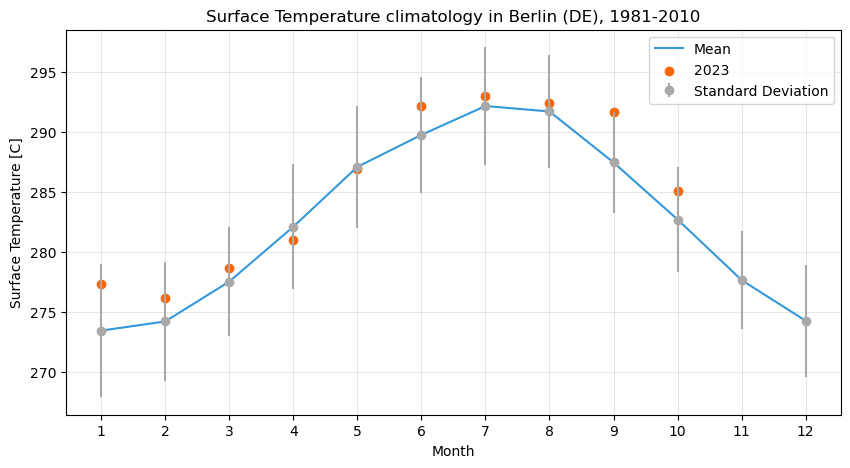

In [16]:
plt.figure(figsize=(10, 5))
t2m_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_climatology_mean.month, 
    t2m_climatology_mean, 
    yerr=t2m_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)
for month in range (1, 11):
    t2m_point = t2m_monthly_mean.sel(valid_time=t2m_monthly_mean["valid_time.month"]==month)
    label = None
    if month == 1:
        label = "2023"
    plt.scatter(month, t2m_point, color="#ff6600", label=label)
plt.title("Surface Temperature climatology in Berlin (DE), 1981-2010")
plt.xticks(t2m_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()